In [2]:
cd /workspace/sunggu/0.Challenge/Med_tutorial_ChatGPT

/workspace/sunggu/0.Challenge/Med_tutorial_ChatGPT


In [3]:
!nvidia-smi
import os
os.environ["CUDA_DEVICE_ORDER"]     =  'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"]  =  '2'
print("CPU 갯수 = ", os.cpu_count())

Thu Jun 29 13:52:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P40           Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   62C    P0   193W / 250W |  13613MiB / 22919MiB |     98%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P40           Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

In [ ]:
# !pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117
# !pip freeze > /workspace/sunggu/0.Challenge/requirements.txt
!pip install -r requirements.txt

# 1. Fix Seed

In [4]:
import random
import numpy as np
import torch

# 시드(seed) 설정
seed = 42

# Python의 random 모듈 시드 설정
random.seed(seed)

# Numpy 시드 설정
np.random.seed(seed)

# Torch 시드 설정
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 2. Log 조사

In [ ]:
'''
[Log analysis]
I want you to act as an AI developer in pytorch and python code for me. 
Please help with coding for implementing the ability to read data from a log file and visualize it in a graph.

Please conduct step by step using the following procedure:
	Step 1: Import the necessary libraries and modules: glob, numpy, matplotlib.pyplot.
	Step 2: Define a read_log function to read a log file. This function takes a file path as an argument, reads the log file, and returns it as a list.
	Step 3: Read the log file using the read_log function. Specify the path as '/workspace/sunggu/0.Challenge/Med_tutorial_ChatGPT/checkpoints/230615_ResNet50_L2_Reg/log.txt'. The read log file is stored in the log_list variable.
	Step 4: Create a dictionary, result_dict, to store the results. Initialize result_dict with the keys from the first dictionary in log_list.
	Step 5: Extract the value corresponding to each key in result_dict from log_list and save it as a list.
	Step 6: Generate a graph. To visualize the results, use matplotlib.pyplot's subplots function. The number of graphs is equal to the number of keys in result_dict, and they are laid out in a vertical orientation. Set the size of the graph via figsize.
	Step 7: Generate a graph for each key in result_dict through a for loop. axs[idx] indicates the subplot to plot at the position corresponding to idx.
	Step 8: Plot the data on the generated graphs. result_dict[key] takes the data corresponding to key and plots the graph. axs[idx].set_title(key) sets the title of the graph to key.
	Step 9: Display the graph. After adjusting the spacing of the graph with plt.tight_layout(), call plt.show() to output the graph.
'''

###########################################################
Metric  =  train_train_loss
Argsort =  [ 85 148 114 140 162]
Value   =  [0.3248083 0.3258454 0.326149  0.3283826 0.3288069]
###########################################################
Metric  =  train_lr
Argsort =  [ 0  6 11 10  8]
Value   =  [0.0001 0.0001 0.0001 0.0001 0.0001]
###########################################################
Metric  =  valid_valid_loss
Argsort =  [5 2 9 8 7]
Value   =  [0.6840946 0.6844637 0.6954987 0.696495  0.6980623]
###########################################################
Metric  =  valid_AUC
Argsort =  [12 13  7 11  8]
Value   =  [0.6681534 0.661463  0.6523937 0.6500149 0.6460749]
###########################################################
Metric  =  valid_F1
Argsort =  [ 7 10 14 12  6]
Value   =  [0.6940299 0.6783217 0.6756757 0.6748971 0.6641791]
###########################################################
Metric  =  valid_Acc
Argsort =  [12  7 13 11  8]
Value   =  [0.6594828 0.6465517 0.

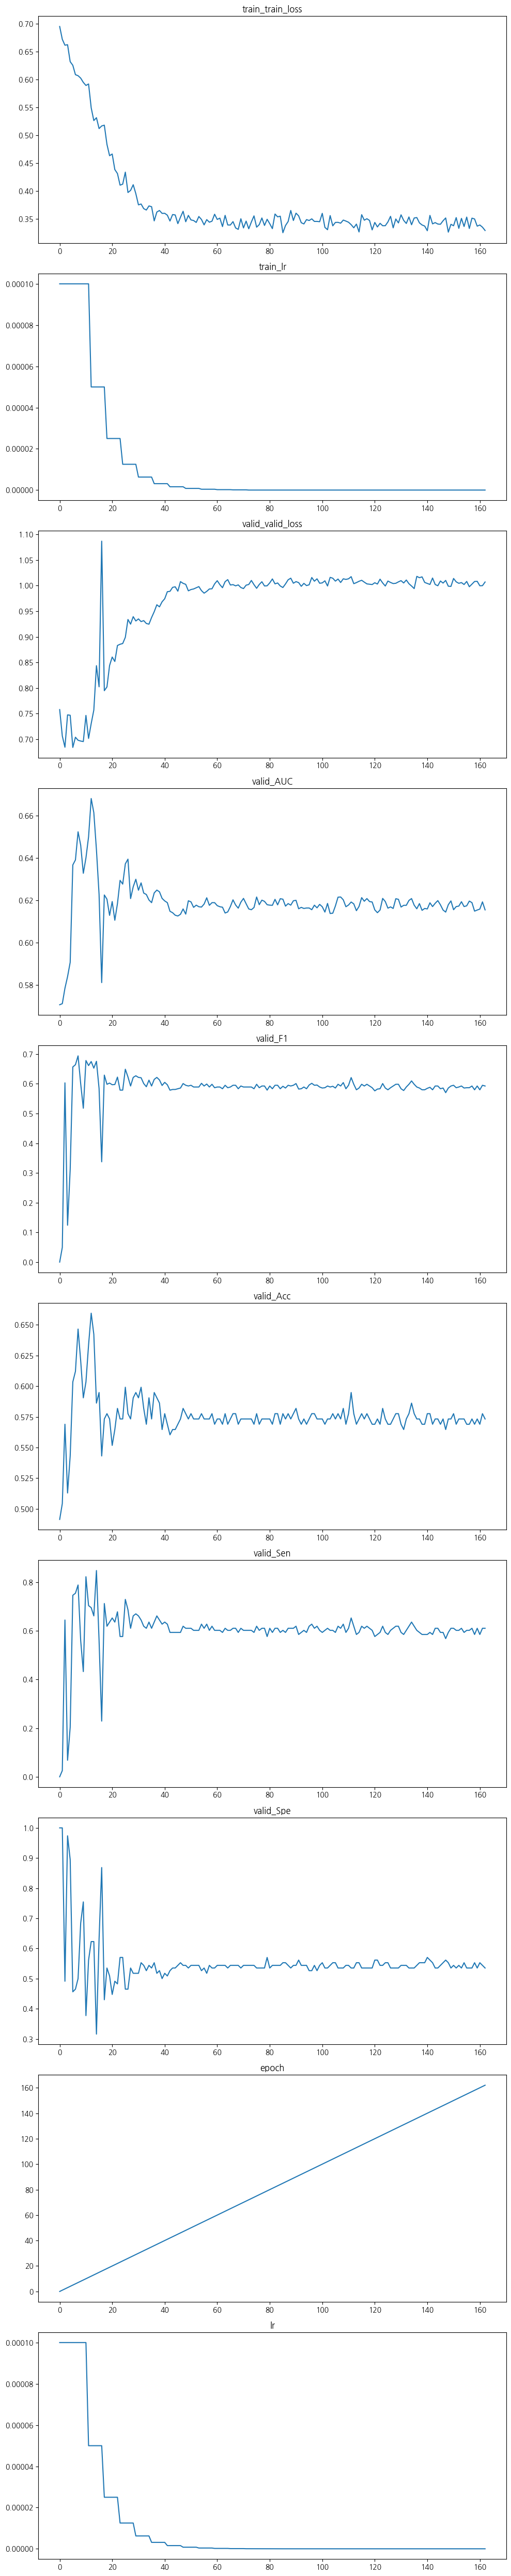

In [5]:
import glob
import numpy as np
import matplotlib.pyplot as plt

def read_log(path):
    log_list = []
    lines = open(path, 'r').read().splitlines() 
    for line in lines:
        log_list.append(eval(line))
    return log_list

log_list = read_log(path='/workspace/sunggu/0.Challenge/Med_tutorial_ChatGPT/checkpoints/230615_ResNet50_L2_Reg/log.txt')

result_dict = {}
for key in log_list[0].keys():
    result_dict[key] = [log[key] for log in log_list]

fig, axs = plt.subplots(len(result_dict.keys()), 1, figsize=(10, len(result_dict.keys())*5))

for idx, key in enumerate(result_dict.keys()):
    axs[idx].plot(result_dict[key])
    axs[idx].set_title(key)
    print("###########################################################")
    print("Metric  = ", key)
    
    if "loss" in key:
        print("Argsort = ", np.argsort(result_dict[key])[:5])
        print("Value   = ", np.array(result_dict[key])[np.argsort(result_dict[key])[:5]])
    else:
        print("Argsort = ", np.argsort(result_dict[key])[::-1][:5])
        print("Value   = ", np.array(result_dict[key])[np.argsort(result_dict[key])[::-1][:5]])

plt.tight_layout()
plt.show()


# 3. Dataset

In [5]:
import os
import re
import cv2
import skimage
import pydicom
import pandas as pd
import albumentations as A
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset

def list_sort_nicely(l):
    def convert(text): return int(text) if text.isdigit() else text
    def alphanum_key(key): return [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

def fixed_clahe(image, **kwargs):
    clahe_mat = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe_mat.apply(image)

def change_to_uint8(image, **kwargs):
    return skimage.util.img_as_ubyte(image)

def change_to_float32(image, **kwargs):
    return skimage.util.img_as_float32(image)

def min_max_normalization(image, **kwargs):
    if len(np.unique(image)) != 1:
        image = image.astype('float32')
        image -= image.min()
        image /= image.max() 
    return image

def get_transforms():
    # medical augmentation
    return A.Compose([
        # Preprocessing
        A.Resize(224, 224),
        A.Lambda(image=min_max_normalization, always_apply=True),
        A.Lambda(image=change_to_uint8, always_apply=True),
        A.Lambda(image=fixed_clahe, always_apply=True),
        A.Lambda(image=change_to_float32, always_apply=True),
        
        # Normalize
        A.Lambda(image=min_max_normalization, always_apply=True),
        A.Normalize(max_pixel_value=1.0, mean=0.5, std=0.5),
        ToTensorV2()
    ])


class RSNA_Dataset(Dataset):
    def __init__(self, mode="test"):
        self.root       = '/workspace/sunggu/0.Challenge/Med_tutorial_ChatGPT/dataset/rsna_data.csv'
        temp_df         = pd.read_csv(self.root)
        self.data_df    = temp_df[temp_df['mode'] == mode]
        self.transforms = get_transforms()
        print(f"len of data: {len(self.data_df)}")

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        img_path = self.data_df['path'].iloc[idx]
        dcm_data = pydicom.dcmread(img_path)
        temp_img = apply_modality_lut(dcm_data.pixel_array, dcm_data)   
        image    = apply_voi_lut(temp_img, dcm_data)                             

        label    = self.data_df['cancer'].iloc[idx]
        label    = torch.tensor(label).float().unsqueeze(0)

        # add channel axis
        image    = np.expand_dims(image, axis=-1)
        image    = self.transforms(image=image)['image']
        
        return image, label
    

In [6]:
from torch.utils.data import DataLoader

# 1. Create Dataset
test_dataset = RSNA_Dataset(mode="test")

# 2. Create DataLoader
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

len of data: 232


# 4. Network

In [7]:
import torch.nn as nn
import torchvision

class ResNet50(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet50, self).__init__()
        self.model = torchvision.models.resnet50(pretrained=pretrained)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(2048, 1)
        
    def forward(self, x):
        return self.model(x)


In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = ResNet50()
num_params = count_parameters(model)
print("Number of learnable parameters: ", num_params)

/home/sunggu/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sunggu/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of Learnable Params: 23503809


# 5. Loss

In [9]:
import torch
import torch.nn as nn

# 인기 있는 손실 함수인 이진 교차 엔트로피 손실(Binary Cross Entropy Loss)을 사용합니다.
criterion = nn.BCEWithLogitsLoss()


# 6. Check the resume point

In [11]:
checkpoint_path = '/workspace/sunggu/0.Challenge/Med_tutorial_ChatGPT/checkpoints/230615_ResNet50_L2_Reg'
save_dir        = '/workspace/sunggu/0.Challenge/Med_tutorial_ChatGPT/predictions/230615_ResNet50_L2_Reg'

# make folder if not exist
os.makedirs(checkpoint_path, exist_ok =True)
os.makedirs(save_dir, exist_ok =True)

In [12]:
# Resume
# Metric  =  valid_F1
# Argsort =  [ 7 10 14 12  6]
# Value   =  [0.6940299 0.6783217 0.6756757 0.6748971 0.6641791]

filename = 'epoch_7_checkpoint.pth'
print("=> loading checkpoint '{}'".format(filename))
checkpoint  = torch.load(os.path.join(checkpoint_path, filename))
model.load_state_dict(checkpoint['model_state_dict'])

=> loading checkpoint 'epoch_7_checkpoint.pth'


<All keys matched successfully>

# 7. Using GPU testing

In [13]:
# using CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 8. Metric

In [14]:
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, confusion_matrix, precision_score

def calculate_metrics(predictions, targets):
    # AUC 계산
    auc = roc_auc_score(targets, predictions)

    # 정확도 계산
    accuracy = accuracy_score(targets, np.round(predictions))

    # F1 점수 계산
    f1 = f1_score(targets, np.round(predictions))

    # 민감도 (재현율) 계산
    sensitivity = recall_score(targets, np.round(predictions))

    # 특이도 계산
    tn, fp, fn, tp = confusion_matrix(targets, np.round(predictions)).ravel()
    specificity = tn / (tn + fp)

    return auc, accuracy, f1, sensitivity, specificity

# 9. Test Loop

In [ ]:
'''
[Define Test Loop function]
I want you to act as an AI developer in pytorch and python code for me. 
Please help with writing a code that performs testing on a model using a testing loop. 
In this code, you will use the AverageMeter class to calculate the average of the metrics, and the test_loop_fn function to perform the testing process.
The code includes functionalities such as calculating metrics, generating Grad-CAM visualizations, and saving the visualizations.
In addition, the test_loop_fn function will utilize a loss function (criterion) to calculate the loss, which will be used to calculate the metrics using 'calculate_metrics' function (accuracy, F1, AUC, sensitivity, and specificity).
The model predicts cancer within an image in a binary classification manner.

Please conduct step by step using the following procedure:
	Step 1: Import the necessary libraries and modules for the code, including time, math, json, tqdm, datetime, matplotlib.pyplot, and defaultdict.
	Step 2: Define the AverageMeter class, which will be used to calculate the average of metrics.
	Step 3: Define the forward_hook function, which serves as the forward hook for capturing intermediate activations.
	Step 4: Define the backward_hook function, which serves as the backward hook for capturing gradients.
	Step 5: Define the min_max_normalization function, which performs min-max normalization on the input image.
	Step 6: Define the test_loop_fn function, which performs testing using the provided model, criterion, and data. The function takes the test_loader, model, criterion, device, and save_dir as arguments.
	Step 7: Set the model to evaluation mode.
	Step 8: Initialize the metric_logger to track the metrics during testing.
	Step 9: Iterate over the batches in the test_loader using the tqdm iterator.
	Step 10: Get the input images and targets from the batch.
	Step 11: Register the forward_hook and backward_hook on the specified layer of the model (resnet50's layer4[2].conv3).
	Step 12: Pass the input images through the model to obtain the logits.
	Step 13: Calculate the loss using the criterion.
	Step 14: Update the metric_logger with the loss value.
	Step 15: Perform post-processing steps, such as storing the predicted probabilities and ground truth values.
	Step 16: Calculate the Grad-CAM visualization by computing the gradients and activations.
	Step 17: Resize the Grad-CAM heatmap to the original image size.
	Step 18: Visualize the image and Grad-CAM heatmap using matplotlib.pyplot.
	Step 19: Save the visualization to a file in the specified save_dir.
	Step 20: Remove the forward_hook and backward_hook.
	Step 21: Concatenate the predicted probabilities and ground truth values to calculate metrics.
	Step 22: Calculate the metrics (AUC, accuracy, F1, sensitivity, specificity) using the calculate_metrics function.
	Step 23: Update the metric_logger with the calculated metrics.
	Step 24: Return the average of the metrics and the ground truth values.

Here is a valid_loop example, so you can refer to it:
<
@torch.no_grad()
def valid_loop_fn(valid_loader, model, criterion, device):
    model.eval()
    metric_logger = AverageMeter()
    # epoch_iterator = tqdm(valid_loader, desc="Validating")
    epoch_iterator = tqdm(valid_loader, desc="Validating (X / X Steps) (loss=X.X)", dynamic_ncols=True, total=len(valid_loader))

    preds = []
    gts = []
    for batch_data in epoch_iterator:
        image, target = batch_data
        image, target = image.to(device), target.to(device)

        logit = model(image)
        loss = criterion(logit, target)
        loss_value = loss.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))

        metric_logger.update(key='valid_loss', value=loss_value, n=image.shape[0])
        # epoch_iterator.set_postfix(loss=loss_value)
        epoch_iterator.set_description("Validating: Epochs %d (%d / %d Steps), (valid_loss=%2.5f)" % (epoch, step, len(valid_loader), loss_value))

        preds.append(logit.sigmoid().squeeze().detach().cpu().numpy())
        gts.append(target.squeeze().detach().cpu().numpy())

    preds = np.concatenate(preds)
    gts = np.concatenate(gts)

    # Calculate metrics
    auc, accuracy, f1, sensitivity, specificity = calculate_metrics(preds, gts)

    metric_logger.update(key='valid_loss', value=loss.item(), n=image.size(0))
    metric_logger.update(key='valid_auc', value=auc, n=image.size(0))
    metric_logger.update(key='valid_accuracy', value=accuracy, n=image.size(0))
    metric_logger.update(key='valid_f1', value=f1, n=image.size(0))
    metric_logger.update(key='valid_sensitivity', value=sensitivity, n=image.size(0))
    metric_logger.update(key='valid_specificity', value=specificity, n=image.size(0))

    return metric_logger.average()
>
'''

In [15]:
import time
import math
import json
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
from collections import defaultdict

class AverageMeter:
    def __init__(self, **kwargs):
        self.reset()

    def reset(self):
        self.data = defaultdict(lambda: {'sum': 0, 'count': 0})

    def update(self, key, value, n):
        self.data[key]['sum']   += value * n
        self.data[key]['count'] += n
    
    def average(self):
        return {k: v['sum'] / v['count'] for k, v in self.data.items()}

# forward hook 정의
def forward_hook(module, input, output):
    global activations
    activations = output.detach()

# backward hook 정의
def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0].detach()

def min_max_normalization(image, **kwargs):
    if np.unique(image).size == 1: # Sometimes it cause the nan inputs...
        return image    
    image = image.astype('float32')
    image -= image.min()
    image /= image.max()
    return image


# @torch.no_grad() -> grad cam을 그릴려면 꺼야한다.
def test_loop_fn(valid_loader, model, criterion, device, save_dir):
    model.eval()
    metric_logger  = AverageMeter()
    epoch_iterator = tqdm(valid_loader, desc="Testing (X / X Steps) (loss=X.X)", dynamic_ncols=True, total=len(valid_loader))

    preds = [] # must be 1d list or array
    gts   = [] # must be 1d list or array
    for step, batch_data in enumerate(epoch_iterator):
        image, target = batch_data
        image, target = image.to(device), target.to(device)
        
        if hasattr(model, 'module'):
            handle_forward  = model.module.model.layer4[2].conv3.register_forward_hook(forward_hook)
            handle_backward = model.module.model.layer4[2].conv3.register_backward_hook(backward_hook)
        
        else: 
            handle_forward  = model.model.layer4[2].conv3.register_forward_hook(forward_hook)
            handle_backward = model.model.layer4[2].conv3.register_backward_hook(backward_hook)

        logit = model(image)
        loss  = criterion(logit, target)
        loss_value = loss.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))

        metric_logger.update(key='test_loss', value=loss_value, n=image.shape[0])
        epoch_iterator.set_description("Testing: (%d / %d Steps), (test_loss=%2.5f)" % (step, len(valid_loader), loss_value))

        # post-processing
        preds.append(logit.sigmoid().squeeze().detach().cpu().numpy())
        gts.append(target.squeeze().detach().cpu().numpy())

        # Grad-CAM
        model.zero_grad()
        logit[:, 0].backward() # score(=scalar)에 대한 gradient 계산. Backward pass with specific '0' class

            # gradients, activations 처리
        weights  = torch.mean(gradients, dim=(2, 3), keepdim=True)            # gradients   = torch.Size([1(=B), 2048, 7, 7])
        grad_cam = torch.sum(weights * activations, dim=1, keepdim=True)      # weights     = torch.Size([1(=B), 2048, 1, 1]),  [B, C, 1, 1] * [B, C, H, W] = [B, 1, H, W]
        grad_cam = torch.relu(grad_cam)                                       # activations = torch.Size([1(=B), 2048, 7, 7])
                                                                              # grad_cam    = torch.Size([1(=B), 1,    7, 7])

            # 시각화를 위해 이미지 크기로 업샘플링
        upsampled_grad_cam = torch.nn.functional.interpolate(grad_cam, size=(224, 224), mode='bilinear', align_corners=False)
        heatmap = upsampled_grad_cam.squeeze().detach().cpu().numpy() # [H, W]

            # 이미지와 Grad-CAM 시각화
        plt.imshow(image.squeeze().detach().cpu().numpy()) # [H, W]
        plt.imshow(min_max_normalization(heatmap), alpha=0.4, cmap='jet') # [H, W]
        plt.axis('off')

        plt.savefig(save_dir + '/gradcam_s[' + str(step) + ']_p[' + str(logit.sigmoid().squeeze().detach().cpu().numpy())[:4] + ']_g[' + str(target.squeeze().detach().cpu().numpy()) + '].jpg', bbox_inches='tight', pad_inches=0)
        plt.close()

            # Hook 제거
        handle_forward.remove()
        handle_backward.remove()       


    # Metric Calculation
    preds = np.concatenate(preds)
    gts = np.concatenate(gts)

    # Calculate metrics
    auc, accuracy, f1, sensitivity, specificity = calculate_metrics(preds, gts)

    metric_logger.update(key='test_loss', value=loss.item(), n=image.size(0))
    metric_logger.update(key='test_auc', value=auc, n=image.size(0))
    metric_logger.update(key='test_accuracy', value=accuracy, n=image.size(0))
    metric_logger.update(key='test_f1', value=f1, n=image.size(0))
    metric_logger.update(key='test_sensitivity', value=sensitivity, n=image.size(0))
    metric_logger.update(key='test_specificity', value=specificity, n=image.size(0))

    return metric_logger.average()
    # return {k: round(v, 7) for k, v in metric_logger.average().items()}

In [36]:
import warnings
warnings.filterwarnings(action='ignore')

print(f"Start training")
start_time = time.time()
    
test_stats = test_loop_fn(test_loader, model, criterion, device, save_dir)
print('==> Averaged Test stats: ' + str(test_stats))

# Finish
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))

Start training


Testing: (231 / 232 Steps), (test_loss=0.24323): 100%|██████████| 232/232 [01:52<00:00,  2.06it/s]

==> Averaged Test stats: {'test_loss': 0.6603113, 'AUC': 0.681237, 'F1': 0.6768061, 'Acc': 0.6336207, 'Sen': 0.7542373, 'Spe': 0.5087719}
Training time 0:01:52
